In [1]:
suppressMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(coloc))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(R.utils))
suppressPackageStartupMessages(library(remotes))
suppressPackageStartupMessages(library(susieR))
library(ggrepel)

suppressMessages(library(RColorBrewer))
suppressMessages(library(factoextra))
suppressMessages(library(car))
suppressMessages(library(umap))
suppressMessages(library(plotly))
suppressMessages(library(crosstalk))
suppressMessages(library(ellipsis))
suppressMessages(library(Rtsne))
suppressMessages(library(ggrepel))
suppressMessages(library(ComplexHeatmap))

In [2]:
hg19_rsid <- fread('/data/UKBB_Neale_v2/variants.tsv.gz')

## Format UKB-PPP proteins for munge LDSC and subset proteins to hapmap rsids

In [3]:
ukb_ppp_manifest <- fread('/UKB-PPP/manifest.csv')
all_proteins <- ukb_ppp_manifest$name
all_proteins <- paste0(all_proteins, '_all_chr.tsv.gz')

In [ ]:
for (x in all_proteins){
    protein <- fread(paste0('/UKB-PPP/', x))
    name <- gsub('_all_chr.tsv.gz', '', x)
    protein$ID <- gsub(':imp:v1', '', protein$ID)

    rsid_merge <- merge(protein, hg19_rsid, by.x='ID', by.y='variant')
    cut <- rsid_merge[which(rsid_merge$rsid %in% map$SNP),]
    fwrite(cut[,c(20,4,5,6,8,10,15)], paste0('/UKB-PPP/LDSC/munge_sumstats/',name,'.hm.cut.tsv'), sep='\t', quote=F, row.names=F, col.names=T)
}

# Save Results Tables

In [88]:
proteins <- list.dirs('/protein_LDSC/', full.names=FALSE)[-1]

In [106]:
for (x in proteins){
    setwd(paste0('/LDSC/', x, '/'))
    files <- list.files(paste0('/LDSC/', x, '/'), pattern='.results')
    res <- data.frame()
    for (y in files){
        res0 <- NULL
        celltype <- gsub(paste0(x, '.'), '', y)
        celltype <- gsub('.results', '', celltype)
        results <- fread(y)
        res0$cell_type <- celltype
        res0$Enrichment <- results$Enrichment[1]
        res0$Enrichment_std_error <- results$Enrichment_std_error[1]
        res0$Enrichment_p <- results$Enrichment_p[1]
        res0 <- as.data.frame(res0)
        res <- rbind(res, res0)
        fetal <- res[grep('Fetal', res$cell_type),]
        res <- res[which(!res$cell_type %in% fetal$cell_type),]
    }
    res <- res[order(res$Enrichment_p),]
    write.table(res, paste0('/LDSC/Results_no_fetal/',x, '_ldscore_results_no_fetal.tsv'), sep = '\t', quote=FALSE, col.names=TRUE, row.names=FALSE)
}

# Make volcano plots for all proteins in a loop

In [9]:
setwd('/LDSC/Results/')
options(repr.plot.width=7, repr.plot.height=6.5)
for (x in proteins){
    protein <- fread(paste0(x, '_ldscore_results.tsv'), header=TRUE)
    fetal_tissues <- grep('Fetal', protein$cell_type, value=TRUE)
    no_fetal <- protein[which(!protein$cell_type %in% fetal_tissues),]
    no_fetal$log10p <- -log10(no_fetal$Enrichment_p)
    no_fetal$padj <- p.adjust(no_fetal$Enrichment_p, method='BH')
    no_fetal$sig <- 'no'
    no_fetal[which(no_fetal$padj <= 0.1),]$sig <- 'yes' #NOTE THIS VALUE
    label_list <- no_fetal[which(no_fetal$sig == 'yes'),]$cell_type
    no_fetal$label <- NA
    no_fetal$label <- as.character(no_fetal$label)
    no_fetal[which(no_fetal$cell_type %in% label_list),]$label <- no_fetal[which(no_fetal$cell_type %in% label_list),]$cell_type
    no_fetal$label <- gsub('__', '_', no_fetal$label) #Some CATlas annotations have double underscores?
    no_fetal$label <- gsub('_', ' ', no_fetal$label) #Some CATlas annotations have double underscores?
    
    if (nrow(no_fetal[which(no_fetal$sig == 'yes'),])>0){
        p1 <- ggplot(data=no_fetal, aes(x=Enrichment, y=log10p, col=sig,label=label, alpha=1)) + theme_classic(base_size=18) +
        geom_point(data =no_fetal %>% filter(sig == 'yes'), color = '#023047', size=5, alpha=0.7, shape=19, stroke=NA) + 
        geom_point(data =no_fetal %>% filter(sig != 'yes'), color = 'grey20', size=4, alpha=0.5, shape=19, stroke=NA) + 
        geom_hline(yintercept= -log10(0.05), col="grey", linetype="dashed") + 
        geom_vline(xintercept=0, col="grey", linetype='dashed') + 
        geom_text_repel(col=c("black"), size=6, alpha=1) +
        xlab('Enrichment') + ylab(expression(paste('-log'[10],'(p-value)'))) +
        ggtitle(str_split_fixed(x,'_',n=2)[1]) +
        theme(legend.position = "none", 
              axis.title.x=element_text(size=22, vjust=0.5), axis.text.x=element_text(size=15, vjust=0.5),
              axis.title.y=element_text(size=22, vjust=0.5), axis.text.y=element_text(size=15, vjust=0.5))
        print(p1)
    }
    else {
        p1 <- ggplot(data=no_fetal, aes(x=Enrichment, y=log10p, col=sig,label=label, alpha=1)) + theme_classic(base_size=18) +
        geom_point(data =no_fetal %>% filter(sig == 'yes'), color = '#023047', size=5, alpha=0.7, shape=19, stroke=NA) + 
        geom_point(data =no_fetal %>% filter(sig != 'yes'), color = 'grey20', size=4, alpha=0.5, shape=19, stroke=NA) + 
        geom_hline(yintercept= -log10(0.05), col="grey", linetype="dashed") + 
        geom_vline(xintercept=0, col="grey", linetype='dashed') + 
        geom_text_repel(col=c("black"), size=6, alpha=1) +
        xlab('Enrichment') + ylab(expression(paste('-log'[10],'(p-value)'))) +
        ggtitle(str_split_fixed(x,'_',n=2)[1]) +
        theme(legend.position = "none", 
              axis.title.x=element_text(size=22, vjust=0.5), axis.text.x=element_text(size=15, vjust=0.5),
              axis.title.y=element_text(size=22, vjust=0.5), axis.text.y=element_text(size=15, vjust=0.5))
        print(p1)
    }
}

In [123]:
result_files <- list.files('/LDSC/Results_no_fetal/', pattern='.tsv')
res_fin <- NULL
for (x in result_files){
    protein <- str_split_fixed(x, '_', n=2)[1]
    res_file <- fread(paste0('/LDSC/Results_no_fetal/',x))
    res_file <- res_file[,c(1,4)]
    res_file$Enrichment_p <- -log10(res_file$Enrichment_p)
    res_file <- res_file[order(res_file$cell_type),]
    rownames(res_file) <- res_file$cell_type
    names(res_file)[2] <- protein
    res_fin <- cbind(res_fin, res_file[,2])
}
rownames(res_fin) <- res_file$cell_type

In [124]:
means <- rowMeans(res_fin)
names(means) <- rownames(res_fin)
celltypes_to_include <- names(means[order(-means)][1:14])
celltypes_to_include <- celltypes_to_include[order(celltypes_to_include)]

res_fin2 <- res_fin[which(rownames(res_fin) %in% celltypes_to_include),]
res_fin2 <- as.matrix(res_fin2)
rownames(res_fin2) <- celltypes_to_include
res_fin3 <- res_fin2[c(1,2,3,4,5,6,7,8,9,10,12,14),]

In [127]:
head(res_fin3)

,ALPI,APBB1IP,APOA1,APOC1,C7,CASP8,CCN3,CPA1,DXO,HLA-DRA,⋯,LGMN,LRPAP1,OSMR,PCDH12,PNLIPRP1,PRSS2,PRSS27,SPAG1,TGFA,TRIM5
Acinar,0.441469865,0.6665047,0.19925074,0.28534049,1.8927836,0.8817402,0.48631039,3.3247681,0.45265151,5.1851317,⋯,0.70112451,0.6290742,0.12735054,0.6762701,4.904515,4.311604,0.7694877,0.07844919,0.1954252,0.9832448
Chief,0.354836490,0.3913076,0.39129890,0.02534588,1.8261338,0.3145283,0.07559771,1.6820701,0.09104556,1.0155662,⋯,0.24212039,0.4003883,0.09717225,0.3795096,4.217642,3.712737,1.4194629,0.64640692,0.5848079,0.4562315
Colon_Epithelial_1,0.393806752,0.2230337,0.29227105,0.63211507,2.4537345,1.0081998,0.87874116,2.6610889,1.10722737,0.5740383,⋯,0.03506713,0.3032378,0.41648522,2.0095874,4.907217,3.588860,0.4798251,0.02637236,0.8894275,0.9500604
Ductal,0.009474386,0.2250079,0.15641858,0.11763382,0.8973516,1.3847776,0.24267100,4.1651406,1.16089448,0.4862865,⋯,1.04853986,0.5268382,0.73684355,1.1411611,5.427836,5.419045,0.3392983,0.31805545,0.2110939,0.6217598
Endothelial_General_1,0.008750661,1.1550954,0.00741617,0.36682256,2.7271532,0.5202625,0.07640082,0.6981200,0.81369619,1.6309829,⋯,1.09006986,1.2508611,0.91995070,0.7960929,1.174138,2.526626,0.9901429,0.09782594,2.2232921,0.1548210
Endothelial_Myocardial,0.372030841,1.1270885,0.06658443,0.17124968,1.3807137,0.7926261,0.27343380,0.7262503,1.24888692,2.0394521,⋯,1.02215321,0.8751117,0.59261770,0.9318987,1.190486,2.227046,0.7818160,0.55626921,2.2679289,0.4676564


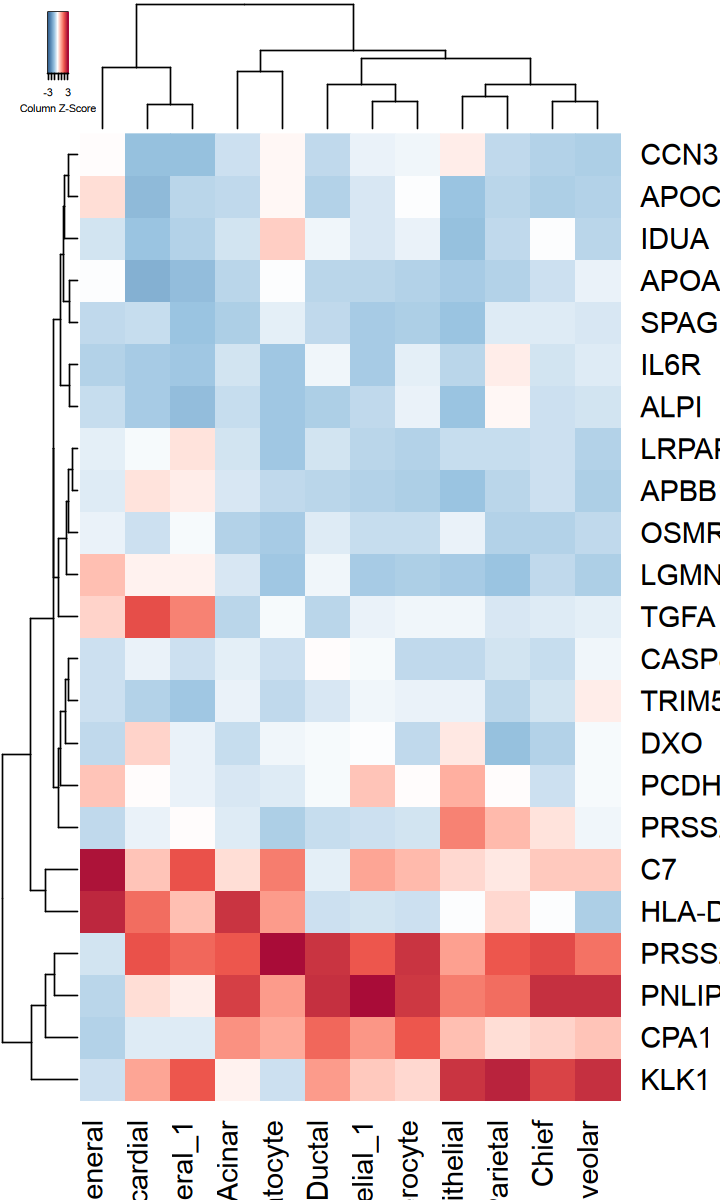

In [131]:
options(repr.plot.width=6, repr.plot.height=10)
# pdf('/heatmap.pdf', width=6, height=10)
hmcol <- paletteer::paletteer_c("ggthemes::Red-Blue-White Diverging", n=100)
hmcol <-rev(hmcol)
gplots::heatmap.2(t(res_fin3),col=hmcol,cexRow = 1.7, cexCol = 1.7, 
                  trace = 'none',scale='col', density.info = 'none', Rowv=TRUE, Colv=TRUE, key.title=NA, keysize=0.5, key.par = list(cex=0.5))
# dev.off()

In [3]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/relgamal/miniconda3/envs/R-notebooks/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ComplexHeatmap_2.16.0 Rtsne_0.17            ellipsis_0.3.2       
 [4] crosstalk_1.2.1       plotly_4.10.4         umap_0.2.10.0        
 [7] car_3.1-2             carData_3.0-5         fac